# Const_prop_PINN 

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
from pyDOE import lhs

def sampling_lhs(res, x_min, x_max, loc, t, e=0.05):
    if isinstance(res, float):
        res = [res, res, res]
    num_points = int((x_max[1] - x_min[1]) / res[1] + 1) * int((x_max[2] - x_min[2]) / res[2] + 1)
    if loc == '-x':
        yp_zp = lhs(2, samples=num_points)
        yp = yp_zp[:, 0] * (x_max[1] - x_min[1]) + x_min[1]
        zp = yp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        xp = np.ones_like(yp) * x_min[0]
        x = np.vstack((xp, yp, zp)).T
    if loc == '+x':
        yp_zp = lhs(2, samples=num_points)
        yp = yp_zp[:, 0] * (x_max[1] - x_min[1]) + x_min[1]
        zp = yp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        xp = np.ones_like(yp) * x_max[0]
        x = np.vstack((xp, yp, zp)).T
    if loc == '-y':
        xp_zp = lhs(2, samples=num_points)
        xp = xp_zp[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
        zp = xp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        yp = np.ones_like(xp) * x_min[1]
        x = np.vstack((xp, yp, zp)).T
    if loc == '+y':
        xp_zp = lhs(2, samples=num_points)
        xp = xp_zp[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
        zp = xp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        yp = np.ones_like(xp) * x_max[1]
        x = np.vstack((xp, yp, zp)).T
    if loc == '+z':
        xp_yp = lhs(2, samples=num_points)
        xp = xp_yp[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
        yp = xp_yp[:, 1] * (x_max[1] - x_min[1]) + x_min[1]
        zp = np.ones_like(xp) * x_max[2]
        x = np.vstack((xp, yp, zp)).T
    if loc == 'domain':
        num_points = int((x_max[0] - x_min[0]) / res[0] + 1) * int((x_max[1] - x_min[1]) / res[1] + 1) * int((x_max[2] - x_min[2]) / res[2] + 1)
        xyz = lhs(3, samples=num_points)
        xp = xyz[:, 0] * (x_max[0] - x_min[0] - 2 * e) + x_min[0] + e
        yp = xyz[:, 1] * (x_max[1] - x_min[1] - 2 * e) + x_min[1] + e
        zp = xyz[:, 2] * (x_max[2] - x_min[2] - 2 * e) + x_min[2] + e
        x = np.vstack((xp, yp, zp)).T

    xt = []
    num = x.shape[0]
    for ti in t:
        xt.append(np.hstack((x, np.full([num, 1], ti))))
    xt = np.vstack(xt)
    return xt, xt.shape[0]

def generate_points(p=[], f=[]):
    t = np.linspace(x_min[3] + 0.01, x_max[3], 61)

    bound_x_neg, _ = sampling_lhs(1., x_min, x_max, '-x', t)
    bound_x_pos, _ = sampling_lhs(1., x_min, x_max, '+x', t)
    bound_y_neg, _ = sampling_lhs(1., x_min, x_max, '-y', t)
    bound_y_pos, _ = sampling_lhs(1., x_min, x_max, '+y', t)
    bound_z_pos, _ = sampling_lhs(1., x_min, x_max, '+z', t)

    domain_pts1, _ = sampling_lhs(2., [x_min[0], x_min[1], x_min[2]], [x_max[0], x_max[1], x_max[2] - 3.], 'domain', t)
    domain_pts2, _ = sampling_lhs(1., [x_min[0], x_min[1], x_max[2] - 3. + .5], [x_max[0], x_max[1], x_max[2] - 1.], 'domain', t)
    domain_pts3 = []
    for ti in t:
        di, _ = sampling_lhs(.5, [x_min[0], x_min[1], x_max[2] - 1. + .25], [x_max[0], x_max[1], x_max[2]], 'domain', [ti])
        domain_pts3.append(di)
    domain_pts3 = np.vstack(domain_pts3)
    domain_pts = np.vstack((domain_pts1, domain_pts2, domain_pts3))

    init_pts1, _ = sampling_lhs(2., [x_min[0], x_min[1], x_min[2]], [x_max[0], x_max[1], x_max[2]], 'domain', [0], e=0)
    init_pts2, _ = sampling_lhs(.5, [x0 - 2, y0 - 2, x_max[2] - 2], [x0 + 2, y0 + 2, x_max[2]], 'domain', [0])
    init_pts = np.vstack((init_pts1, init_pts2))

    p.extend([torch.tensor(bound_x_neg, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_x_pos, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_y_neg, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_y_pos, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_z_pos, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(init_pts, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(domain_pts, requires_grad=True, dtype=torch.float).to(device)])
    f.extend([['BC', '-x'], ['BC', '+x'], ['BC', '-y'], ['BC', '+y'], ['BC', '+z'], ['IC', T_ref], ['domain']])
    
    return p, f

def BC(x, y, z, t, net, loc):
    X = torch.cat([x, y, z, t], axis=-1)
    T = net(X)

    if loc == '-x':
        T_x = grad(T, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return k * T_x - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '+x':
        T_x = grad(T, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_x - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '-y':
        T_y = grad(T, y, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return k * T_y - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '+y':
        T_y = grad(T, y, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_y - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '+z':
        T_z = grad(T, z, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_z - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)

def output_transform(X):
    X = T_range * nn.Softplus()(X) + T_ref
    return X

def input_transform(X):
    X = 2. * (X - X_min) / (X_max - X_min) - 1.
    return X

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def PDE(x, y, z, t, net):
    X = torch.cat([x, y, z, t], axis=-1)
    T = net(X)
    T_t = grad(T, t, create_graph=True, grad_outputs=torch.ones_like(T))[0]

    T_x = grad(T, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
    T_xx = grad(T_x, x, create_graph=True, grad_outputs=torch.ones_like(T_x))[0]
    
    T_y = grad(T, y, create_graph=True, grad_outputs=torch.ones_like(T))[0]
    T_yy = grad(T_y, y, create_graph=True, grad_outputs=torch.ones_like(T_y))[0]
    
    T_z = grad(T, z, create_graph=True, grad_outputs=torch.ones_like(T))[0]
    T_zz = grad(T_z, z, create_graph=True, grad_outputs=torch.ones_like(T_z))[0]

    q_f = torch.zeros_like(x)
    q_r = torch.zeros_like(x)
    
    condition = x - x0 - v * t > 0
    r02 = torch.where(
        condition,
        ((x - x0 - v * t) ** 2 / af ** 2) + ((y - y0) ** 2 / b ** 2) + ((z - z0) ** 2 / c ** 2),
        ((x - x0 - v * t) ** 2 / ar ** 2) + ((y - y0) ** 2 / b ** 2) + ((z - z0) ** 2 / c ** 2)
    )

    q = torch.where(
        condition,
        (6 * (3 ** (1/3)) * ff * eta * U * I / (af * b * c * 3.14159 * 1.7724)) * torch.exp(-3 * r02),
        (6 * (3 ** (1/3)) * fr * eta * U * I / (ar * b * c * 3.14159 * 1.7724)) * torch.exp(-3 * r02)
    )
    
    f = rho * Cp * T_t - k * (T_xx + T_yy + T_zz) - q
    return f

# Parameters
ar = 3.34
af = 1.002
b = 1.67
c = 1.67
v = 10.0
U = 15.3
I = 120.0
eta = 0.9
ff = 0.46
fr = 2 - ff

xmax = 40.0
xmin = 0.0
ymax = 10.0
ymin = 0.0
zmax = 6.0
zmin = 0.0
tmax = 3.0
tmin = 0.0

x0 = 5.0
y0 = 5.0
z0 = 6.0
t_end = 3.0
h = 2e-5
emiss = 0.3
rho = 7.966e-3
Rboltz = 5.6704e-14

x_max = np.array([xmax, ymax, zmax, tmax])
x_min = np.array([xmin, ymin, zmin, tmin])
X_max = torch.tensor(x_max, dtype=torch.float).to(device)
X_min = torch.tensor(x_min, dtype=torch.float).to(device)
Cp = 0.6
k = 0.024
T_ref = 298.15
T_range = 4800

iterations = 50000
lr = 2e-4

# Define the neural network model
class FNN(nn.Module):
    def __init__(self, layers, activation, in_tf=None, out_tf=None):
        super().__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        self.in_tf = in_tf
        self.out_tf = out_tf
        for i in range(1, len(layers)):
            self.linears.append(nn.Linear(layers[i-1], layers[i]))
            nn.init.xavier_uniform_(self.linears[-1].weight)
            nn.init.zeros_(self.linears[-1].bias)
    
    def forward(self, inputs):
        X = inputs
        if self.in_tf:
            X = self.in_tf(X)
        for linear in self.linears[:-1]:
            X = self.activation(linear(X))
        X = self.linears[-1](X)
        if self.out_tf:
            X = self.out_tf(X)
        return X

net = FNN([4, 64, 64, 64, 1], nn.Tanh(), in_tf=input_transform, out_tf=output_transform)
net.to(device)

point_sets, flags = generate_points([], [])

# Loss function
def loss(f, target=None):
    if target is None:
        return torch.sum(torch.square(f)) / f.shape[0]
    if isinstance(target, float):
        return torch.sum(torch.square(f - target)) / f.shape[0]
    else:
        return nn.MSELoss()(f, target)

# Training function
def train(net, PDE, BC, point_sets, flags, iterations=50000, lr=5e-4, info_num=100, test_in=None, test_out=None, w=[1., 1., 1., 1.]):
    params = list(net.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

    n_bc = 0
    n_ic = 0
    n_PDE = 0
    n_data = 0
    for points, flag in zip(point_sets, flags):
        if flag[0] == 'BC':
            n_bc += points.shape[0]
        if flag[0] == 'IC':
            n_ic += points.shape[0]
        if flag[0] == 'domain':
            n_PDE += points.shape[0]
        if flag[0] == 'data':
            n_data += points.shape[0]

    start_time = time.time()

    l_history = []
    if test_in is not None:
        err_history = []

    for epoch in range(iterations):
        optimizer.zero_grad()
        l_BC = 0
        l_IC = 0
        l_PDE = 0
        l_data = 0

        for points, flag in zip(point_sets, flags):
            if flag[0] == 'BC':
                f = BC(points[:, 0:1], points[:, 1:2], points[:, 2:3], points[:, 3:4], net, flag[1])
                l_BC += loss(f) * points.shape[0] / n_bc
            if flag[0] == 'IC':
                pred = net(points)
                l_IC += loss(pred, flag[1]) * points.shape[0] / n_ic
            if flag[0] == 'data':
                pred = net(points)
                l_data += loss(pred, flag[1]) * points.shape[0] / n_data
            if flag[0] == 'domain':
                f = PDE(points[:, 0:1], points[:, 1:2], points[:, 2:3], points[:, 3:4], net)
                l_PDE += loss(f) * points.shape[0] / n_PDE

        if n_data == 0:
            cost = (w[0] * l_BC + w[1] * l_IC + w[2] * l_PDE) / 3
            l_history.append([cost.item(), l_BC.item(), l_IC.item(), l_PDE.item()])

            if epoch % info_num == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, BC: %.3e, IC: %.3e, PDE: %.3e, Time: %.2f' % (epoch, cost, l_BC, l_IC, l_PDE, elapsed))
                start_time = time.time()

            if epoch % 1000 == 0:
                # Save plots and model
                plot_loss_curves(l_history, filename=f"/home/jagadeeswaran/Sequential_PINN/loss_curves_{epoch}.png")
                plot_predictions_3D(net, X_min, X_max, T_range, T_ref, epoch, filename=f"/home/jagadeeswaran/Sequential_PINN/predictions_3D_{epoch}.png")
                torch.save(net.state_dict(), f"/home/jagadeeswaran/Sequential_PINN/model_epoch_{epoch}.pt")

        cost.backward()
        optimizer.step()

    return l_history

# Plotting functions
def plot_points_2D(point_sets, flags, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/2D_top_surface.png"):
    plt.figure(figsize=(10, 8))
    markers = {'domain': 'o', 'BC': 'x', 'IC': 's'}
    colors = {'domain': 'blue', 'BC': 'red', 'IC': 'green'}
    
    for points, flag in zip(point_sets, flags):
        points = points.detach().cpu().numpy()
        label = f"{flag[0]} {flag[1]}" if flag[0] == 'BC' else flag[0]
        plt.scatter(points[:, 0], points[:, 1], c=colors[flag[0]], marker=markers[flag[0]], label=label, s=1)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Top Surface')
    plt.savefig(filename)
    plt.close()

def plot_points_3D(point_sets, flags, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/3D_domain.png"):
    fig = plt.figure(figsize=(15, 12), dpi=300)  # Increase figure size and DPI for higher resolution
    ax = fig.add_subplot(111, projection='3d')
    markers = {'domain': 'o', 'BC': 'x', 'IC': 's'}
    colors = {
        'domain': 'blue', 
        'BC': 'red', 
        'IC': 'green', 
        'BC -x': 'cyan', 
        'BC +x': 'magenta', 
        'BC -y': 'yellow', 
        'BC +y': 'black',
        'BC +z': 'purple'
    }
    
    for points, flag in zip(point_sets, flags):
        points = points.detach().cpu().numpy()
        label = f"{flag[0]} {flag[1]}" if flag[0] == 'BC' else flag[0]
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors.get(label, 'blue'), marker=markers[flag[0]], label=label, s=20, alpha=0.6)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel('z', fontsize=12)
    ax.set_title('3D Scatter Plot of Points in the Domain', fontsize=15)

    # Maintain aspect ratio
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    
    ax.set_box_aspect([xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]])  # Aspect ratio is 1:1:1

    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

def plot_loss_curves(l_history, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/loss_curves.png"):
    l_history = np.array(l_history)
    plt.figure(figsize=(10, 8))
    plt.plot(l_history[:, 0], label='Total Loss')
    plt.plot(l_history[:, 1], label='BC Loss')
    plt.plot(l_history[:, 2], label='IC Loss')
    plt.plot(l_history[:, 3], label='PDE Loss')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig(filename)
    plt.close()

def plot_predictions_3D(net, X_min, X_max, T_range, T_ref, epoch, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/predictions_3D.png"):
    x = np.linspace(X_min.cpu().numpy()[0], X_max.cpu().numpy()[0], 50)
    y = np.linspace(X_min.cpu().numpy()[1], X_max.cpu().numpy()[1], 50)
    z = np.linspace(X_min.cpu().numpy()[2], X_max.cpu().numpy()[2], 50)
    t_vals = [0, 1, 2, 3]

    fig = plt.figure(figsize=(20, 15), dpi=300)  # Increase figure size and DPI for higher resolution

    for i, t in enumerate(t_vals):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        X, Y, Z = np.meshgrid(x, y, z)
        points = np.stack([X.ravel(), Y.ravel(), Z.ravel(), np.full_like(X.ravel(), t)], axis=-1)
        points = torch.tensor(points, dtype=torch.float32).to(next(net.parameters()).device)
        predictions = net(points).detach().cpu().numpy().reshape(50, 50, 50)

        sc = ax.scatter(X, Y, Z, c=predictions.ravel(), cmap='jet', marker='o', s=20, alpha=0.6)
        cbar = fig.colorbar(sc, ax=ax, label='U(t,x,y,z)')
        cbar.ax.tick_params(labelsize=12)
        ax.set_title(f"Time: {t}", fontsize=15)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_zlabel('z', fontsize=12)

        # Maintain aspect ratio
        xlim = ax.get_xlim3d()
        ylim = ax.get_ylim3d()
        zlim = ax.get_zlim3d()
        
        ax.set_box_aspect([xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]])  # Aspect ratio is 1:1:1

    plt.suptitle(f"3D Predictions at Epoch {epoch}", fontsize=18)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

net = FNN([4, 64, 64, 64, 1], nn.Tanh(), in_tf=input_transform, out_tf=output_transform)
net.to(device)

point_sets, flags = generate_points([], [])

# Plot initial points
plot_points_2D(point_sets, flags, filename="/home/jagadeeswaran/Sequential_PINN/2D_top_surface_initial.png")
plot_points_3D(point_sets, flags, filename="/home/jagadeeswaran/Sequential_PINN/3D_domain_initial.png")

l_history = train(net, PDE, BC, point_sets, flags, iterations, lr=lr, info_num=100, w=[1e-2,1e-2, 1.5])

# Save the final model
torch.save(net.state_dict(), "/home/jagadeeswaran/Sequential_PINN/final_model.pt")


It: 0, Loss: 2.132e+04, BC: 1.904e+01, IC: 6.328e+06, PDE: 4.425e+02, Time: 0.12
It: 100, Loss: 8.060e+02, BC: 2.020e+03, IC: 1.428e+05, PDE: 6.467e+02, Time: 55.34
It: 200, Loss: 5.396e+02, BC: 3.862e+03, IC: 5.060e+04, PDE: 7.162e+02, Time: 17.46
It: 300, Loss: 4.626e+02, BC: 3.972e+03, IC: 3.318e+04, PDE: 6.774e+02, Time: 17.45
It: 400, Loss: 4.051e+02, BC: 3.760e+03, IC: 2.529e+04, PDE: 6.166e+02, Time: 17.46
It: 500, Loss: 3.569e+02, BC: 3.316e+03, IC: 1.916e+04, PDE: 5.640e+02, Time: 17.46
It: 600, Loss: 3.179e+02, BC: 2.582e+03, IC: 1.394e+04, PDE: 5.256e+02, Time: 17.45
It: 700, Loss: 2.888e+02, BC: 1.752e+03, IC: 9.852e+03, PDE: 5.001e+02, Time: 17.47
It: 800, Loss: 2.687e+02, BC: 1.072e+03, IC: 6.928e+03, PDE: 4.840e+02, Time: 17.48
It: 900, Loss: 2.554e+02, BC: 6.169e+02, IC: 4.949e+03, PDE: 4.737e+02, Time: 17.50
It: 1000, Loss: 2.467e+02, BC: 3.439e+02, IC: 3.628e+03, PDE: 4.670e+02, Time: 17.49
It: 1100, Loss: 2.409e+02, BC: 1.884e+02, IC: 2.736e+03, PDE: 4.624e+02, Time:

# Testing 

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
from pyDOE import lhs

def sampling_lhs(res, x_min, x_max, loc, t, e=0.05):
    if isinstance(res, float):
        res = [res, res, res]
    num_points = int((x_max[1] - x_min[1]) / res[1] + 1) * int((x_max[2] - x_min[2]) / res[2] + 1)
    if loc == '-x':
        yp_zp = lhs(2, samples=num_points)
        yp = yp_zp[:, 0] * (x_max[1] - x_min[1]) + x_min[1]
        zp = yp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        xp = np.ones_like(yp) * x_min[0]
        x = np.vstack((xp, yp, zp)).T
    if loc == '+x':
        yp_zp = lhs(2, samples=num_points)
        yp = yp_zp[:, 0] * (x_max[1] - x_min[1]) + x_min[1]
        zp = yp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        xp = np.ones_like(yp) * x_max[0]
        x = np.vstack((xp, yp, zp)).T
    if loc == '-y':
        xp_zp = lhs(2, samples=num_points)
        xp = xp_zp[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
        zp = xp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        yp = np.ones_like(xp) * x_min[1]
        x = np.vstack((xp, yp, zp)).T
    if loc == '+y':
        xp_zp = lhs(2, samples=num_points)
        xp = xp_zp[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
        zp = xp_zp[:, 1] * (x_max[2] - x_min[2]) + x_min[2]
        yp = np.ones_like(xp) * x_max[1]
        x = np.vstack((xp, yp, zp)).T
    if loc == '+z':
        xp_yp = lhs(2, samples=num_points)
        xp = xp_yp[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
        yp = xp_yp[:, 1] * (x_max[1] - x_min[1]) + x_min[1]
        zp = np.ones_like(xp) * x_max[2]
        x = np.vstack((xp, yp, zp)).T
    if loc == 'domain':
        num_points = int((x_max[0] - x_min[0]) / res[0] + 1) * int((x_max[1] - x_min[1]) / res[1] + 1) * int((x_max[2] - x_min[2]) / res[2] + 1)
        xyz = lhs(3, samples=num_points)
        xp = xyz[:, 0] * (x_max[0] - x_min[0] - 2 * e) + x_min[0] + e
        yp = xyz[:, 1] * (x_max[1] - x_min[1] - 2 * e) + x_min[1] + e
        zp = xyz[:, 2] * (x_max[2] - x_min[2] - 2 * e) + x_min[2] + e
        x = np.vstack((xp, yp, zp)).T

    xt = []
    num = x.shape[0]
    for ti in t:
        xt.append(np.hstack((x, np.full([num, 1], ti))))
    xt = np.vstack(xt)
    return xt, xt.shape[0]

def generate_points(p=[], f=[]):
    t = np.linspace(x_min[3] + 0.01, x_max[3], 61)

    bound_x_neg, _ = sampling_lhs(1., x_min, x_max, '-x', t)
    bound_x_pos, _ = sampling_lhs(1., x_min, x_max, '+x', t)
    bound_y_neg, _ = sampling_lhs(1., x_min, x_max, '-y', t)
    bound_y_pos, _ = sampling_lhs(1., x_min, x_max, '+y', t)
    bound_z_pos, _ = sampling_lhs(1., x_min, x_max, '+z', t)

    domain_pts1, _ = sampling_lhs(2., [x_min[0], x_min[1], x_min[2]], [x_max[0], x_max[1], x_max[2] - 3.], 'domain', t)
    domain_pts2, _ = sampling_lhs(1., [x_min[0], x_min[1], x_max[2] - 3. + .5], [x_max[0], x_max[1], x_max[2] - 1.], 'domain', t)
    domain_pts3 = []
    for ti in t:
        di, _ = sampling_lhs(.5, [x_min[0], x_min[1], x_max[2] - 1. + .25], [x_max[0], x_max[1], x_max[2]], 'domain', [ti])
        domain_pts3.append(di)
    domain_pts3 = np.vstack(domain_pts3)
    domain_pts = np.vstack((domain_pts1, domain_pts2, domain_pts3))

    init_pts1, _ = sampling_lhs(2., [x_min[0], x_min[1], x_min[2]], [x_max[0], x_max[1], x_max[2]], 'domain', [0], e=0)
    init_pts2, _ = sampling_lhs(.5, [x0 - 2, y0 - 2, x_max[2] - 2], [x0 + 2, y0 + 2, x_max[2]], 'domain', [0])
    init_pts = np.vstack((init_pts1, init_pts2))

    p.extend([torch.tensor(bound_x_neg, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_x_pos, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_y_neg, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_y_pos, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(bound_z_pos, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(init_pts, requires_grad=True, dtype=torch.float).to(device),
              torch.tensor(domain_pts, requires_grad=True, dtype=torch.float).to(device)])
    f.extend([['BC', '-x'], ['BC', '+x'], ['BC', '-y'], ['BC', '+y'], ['BC', '+z'], ['IC', T_ref], ['domain']])
    
    return p, f

def BC(x, y, z, t, net, loc):
    X = torch.cat([x, y, z, t], axis=-1)
    T = net(X)

    if loc == '-x':
        T_x = grad(T, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return k * T_x - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '+x':
        T_x = grad(T, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_x - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '-y':
        T_y = grad(T, y, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return k * T_y - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '+y':
        T_y = grad(T, y, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_y - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)
    if loc == '+z':
        T_z = grad(T, z, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_z - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4)

def output_transform(X):
    X = T_range * nn.Softplus()(X) + T_ref
    return X

def input_transform(X):
    X = 2. * (X - X_min) / (X_max - X_min) - 1.
    return X

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def PDE(x, y, z, t, net):
    X = torch.cat([x, y, z, t], axis=-1)
    T = net(X)
    T_t = grad(T, t, create_graph=True, grad_outputs=torch.ones_like(T))[0]

    T_x = grad(T, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
    T_xx = grad(T_x, x, create_graph=True, grad_outputs=torch.ones_like(T_x))[0]
    
    T_y = grad(T, y, create_graph=True, grad_outputs=torch.ones_like(T))[0]
    T_yy = grad(T_y, y, create_graph=True, grad_outputs=torch.ones_like(T_y))[0]
    
    T_z = grad(T, z, create_graph=True, grad_outputs=torch.ones_like(T))[0]
    T_zz = grad(T_z, z, create_graph=True, grad_outputs=torch.ones_like(T_z))[0]

    q_f = torch.zeros_like(x)
    q_r = torch.zeros_like(x)
    
    condition = x - x0 - v * t > 0
    r02 = torch.where(
        condition,
        ((x - x0 - v * t) ** 2 / af ** 2) + ((y - y0) ** 2 / b ** 2) + ((z - z0) ** 2 / c ** 2),
        ((x - x0 - v * t) ** 2 / ar ** 2) + ((y - y0) ** 2 / b ** 2) + ((z - z0) ** 2 / c ** 2)
    )

    q = torch.where(
        condition,
        (6 * (3 ** (1/3)) * ff * eta * U * I / (af * b * c * 3.14159 * 1.7724)) * torch.exp(-3 * r02),
        (6 * (3 ** (1/3)) * fr * eta * U * I / (ar * b * c * 3.14159 * 1.7724)) * torch.exp(-3 * r02)
    )
    
    f = rho * Cp * T_t - k * (T_xx + T_yy + T_zz) - q
    return f

# Parameters
ar = 3.34
af = 1.002
b = 1.67
c = 1.67
v = 10.0
U = 15.3
I = 120.0
eta = 0.9
ff = 0.46
fr = 2 - ff

xmax = 40.0
xmin = 0.0
ymax = 10.0
ymin = 0.0
zmax = 6.0
zmin = 0.0
tmax = 3.0
tmin = 0.0

x0 = 5.0
y0 = 5.0
z0 = 6.0
t_end = 3.0
h = 2e-5
emiss = 0.3
rho = 7.966e-3
Rboltz = 5.6704e-14

x_max = np.array([xmax, ymax, zmax, tmax])
x_min = np.array([xmin, ymin, zmin, tmin])
X_max = torch.tensor(x_max, dtype=torch.float).to(device)
X_min = torch.tensor(x_min, dtype=torch.float).to(device)
Cp = 0.6
k = 0.024
T_ref = 298.15
T_range = 4800

iterations = 50000
lr = 2e-4

# Define the neural network model
class FNN(nn.Module):
    def __init__(self, layers, activation, in_tf=None, out_tf=None):
        super().__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        self.in_tf = in_tf
        self.out_tf = out_tf
        for i in range(1, len(layers)):
            self.linears.append(nn.Linear(layers[i-1], layers[i]))
            nn.init.xavier_uniform_(self.linears[-1].weight)
            nn.init.zeros_(self.linears[-1].bias)
    
    def forward(self, inputs):
        X = inputs
        if self.in_tf:
            X = self.in_tf(X)
        for linear in self.linears[:-1]:
            X = self.activation(linear(X))
        X = self.linears[-1](X)
        if self.out_tf:
            X = self.out_tf(X)
        return X

net = FNN([4, 64, 64, 64, 1], nn.Tanh(), in_tf=input_transform, out_tf=output_transform)
net.to(device)

point_sets, flags = generate_points([], [])

# Loss function
def loss(f, target=None):
    if target is None:
        return torch.sum(torch.square(f)) / f.shape[0]
    if isinstance(target, float):
        return torch.sum(torch.square(f - target)) / f.shape[0]
    else:
        return nn.MSELoss()(f, target)

# Training function
def train(net, PDE, BC, point_sets, flags, iterations=50000, lr=5e-4, info_num=100, test_in=None, test_out=None, w=[1., 1., 1., 1.]):
    params = list(net.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

    n_bc = 0
    n_ic = 0
    n_PDE = 0
    n_data = 0
    for points, flag in zip(point_sets, flags):
        if flag[0] == 'BC':
            n_bc += points.shape[0]
        if flag[0] == 'IC':
            n_ic += points.shape[0]
        if flag[0] == 'domain':
            n_PDE += points.shape[0]
        if flag[0] == 'data':
            n_data += points.shape[0]

    start_time = time.time()

    l_history = []
    if test_in is not None:
        err_history = []

    for epoch in range(iterations):
        optimizer.zero_grad()
        l_BC = 0
        l_IC = 0
        l_PDE = 0
        l_data = 0

        for points, flag in zip(point_sets, flags):
            if flag[0] == 'BC':
                f = BC(points[:, 0:1], points[:, 1:2], points[:, 2:3], points[:, 3:4], net, flag[1])
                l_BC += loss(f) * points.shape[0] / n_bc
            if flag[0] == 'IC':
                pred = net(points)
                l_IC += loss(pred, flag[1]) * points.shape[0] / n_ic
            if flag[0] == 'data':
                pred = net(points)
                l_data += loss(pred, flag[1]) * points.shape[0] / n_data
            if flag[0] == 'domain':
                f = PDE(points[:, 0:1], points[:, 1:2], points[:, 2:3], points[:, 3:4], net)
                l_PDE += loss(f) * points.shape[0] / n_PDE

        if n_data == 0:
            cost = (w[0] * l_BC + w[1] * l_IC + w[2] * l_PDE) / 3
            l_history.append([cost.item(), l_BC.item(), l_IC.item(), l_PDE.item()])

            if epoch % info_num == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, BC: %.3e, IC: %.3e, PDE: %.3e, Time: %.2f' % (epoch, cost, l_BC, l_IC, l_PDE, elapsed))
                start_time = time.time()

            if epoch % 1000 == 0:
                # Save plots and model
                plot_loss_curves(l_history, filename=f"/home/jagadeeswaran/Sequential_PINN/loss_curves_{epoch}.png")
                plot_predictions_3D(net, X_min, X_max, T_range, T_ref, epoch, filename=f"/home/jagadeeswaran/Sequential_PINN/predictions_3D_{epoch}.png")
                torch.save(net.state_dict(), f"/home/jagadeeswaran/Sequential_PINN/model_epoch_{epoch}.pt")

        cost.backward()
        optimizer.step()

    return l_history

# Plotting functions
def plot_points_2D(point_sets, flags, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/2D_top_surface.png"):
    plt.figure(figsize=(10, 8))
    markers = {'domain': 'o', 'BC': 'x', 'IC': 's'}
    colors = {'domain': 'blue', 'BC': 'red', 'IC': 'green'}
    
    for points, flag in zip(point_sets, flags):
        points = points.detach().cpu().numpy()
        label = f"{flag[0]} {flag[1]}" if flag[0] == 'BC' else flag[0]
        plt.scatter(points[:, 0], points[:, 1], c=colors[flag[0]], marker=markers[flag[0]], label=label, s=1)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Top Surface')
    plt.savefig(filename)
    plt.close()

def plot_points_3D(point_sets, flags, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/3D_domain.png"):
    fig = plt.figure(figsize=(15, 12), dpi=300)  # Increase figure size and DPI for higher resolution
    ax = fig.add_subplot(111, projection='3d')
    markers = {'domain': 'o', 'BC': 'x', 'IC': 's'}
    colors = {
        'domain': 'blue', 
        'BC': 'red', 
        'IC': 'green', 
        'BC -x': 'cyan', 
        'BC +x': 'magenta', 
        'BC -y': 'yellow', 
        'BC +y': 'black',
        'BC +z': 'purple'
    }
    
    for points, flag in zip(point_sets, flags):
        points = points.detach().cpu().numpy()
        label = f"{flag[0]} {flag[1]}" if flag[0] == 'BC' else flag[0]
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors.get(label, 'blue'), marker=markers[flag[0]], label=label, s=20, alpha=0.6)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel('z', fontsize=12)
    ax.set_title('3D Scatter Plot of Points in the Domain', fontsize=15)

    # Maintain aspect ratio
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    
    ax.set_box_aspect([xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]])  # Aspect ratio is 1:1:1

    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

def plot_loss_curves(l_history, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/loss_curves.png"):
    l_history = np.array(l_history)
    plt.figure(figsize=(10, 8))
    plt.plot(l_history[:, 0], label='Total Loss')
    plt.plot(l_history[:, 1], label='BC Loss')
    plt.plot(l_history[:, 2], label='IC Loss')
    plt.plot(l_history[:, 3], label='PDE Loss')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig(filename)
    plt.close()

def plot_predictions_3D(net, X_min, X_max, T_range, T_ref, epoch, filename="/home/jagadeeswaran/Physics_informed_AM-main/temp_dependent_files/Trail_2/predictions_3D.png"):
    x = np.linspace(X_min.cpu().numpy()[0], X_max.cpu().numpy()[0], 50)
    y = np.linspace(X_min.cpu().numpy()[1], X_max.cpu().numpy()[1], 50)
    z = np.linspace(X_min.cpu().numpy()[2], X_max.cpu().numpy()[2], 50)
    t_vals = [0, 1, 2, 3]

    fig = plt.figure(figsize=(20, 15), dpi=300)  # Increase figure size and DPI for higher resolution

    for i, t in enumerate(t_vals):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        X, Y, Z = np.meshgrid(x, y, z)
        points = np.stack([X.ravel(), Y.ravel(), Z.ravel(), np.full_like(X.ravel(), t)], axis=-1)
        points = torch.tensor(points, dtype=torch.float32).to(next(net.parameters()).device)
        predictions = net(points).detach().cpu().numpy().reshape(50, 50, 50)

        sc = ax.scatter(X, Y, Z, c=predictions.ravel(), cmap='jet', marker='o', s=20, alpha=0.6)
        cbar = fig.colorbar(sc, ax=ax, label='U(t,x,y,z)')
        cbar.ax.tick_params(labelsize=12)
        ax.set_title(f"Time: {t}", fontsize=15)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_zlabel('z', fontsize=12)

        # Maintain aspect ratio
        xlim = ax.get_xlim3d()
        ylim = ax.get_ylim3d()
        zlim = ax.get_zlim3d()
        
        ax.set_box_aspect([xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]])  # Aspect ratio is 1:1:1

    plt.suptitle(f"3D Predictions at Epoch {epoch}", fontsize=18)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

net = FNN([4, 64, 64, 64, 1], nn.Tanh(), in_tf=input_transform, out_tf=output_transform)
net.to(device)

point_sets, flags = generate_points([], [])

# Plot initial points
#plot_points_2D(point_sets, flags, filename="/home/jagadeeswaran/Sequential_PINN/2D_top_surface_initial.png")
#plot_points_3D(point_sets, flags, filename="/home/jagadeeswaran/Sequential_PINN/3D_domain_initial.png")

#l_history = train(net, PDE, BC, point_sets, flags, iterations, lr=lr, info_num=100, w=[1e-2,1e-2, 1.5])

# Save the final model
#torch.save(net.state_dict(), "/home/jagadeeswaran/Sequential_PINN/final_model.pt")
n_bc = sum([points.shape[0] for points, flag in zip(point_sets, flags) if flag[0] == 'BC'])
n_ic = sum([points.shape[0] for points, flag in zip(point_sets, flags) if flag[0] == 'IC'])
n_PDE = sum([points.shape[0] for points, flag in zip(point_sets, flags) if flag[0] == 'domain'])

In [25]:
print(n_bc, n_ic, n_PDE)

23485 909 277916


In [26]:

net.load_state_dict(torch.load('/home/jagadeeswaran/Sequential_PINN/final_model.pt', map_location=torch.device('cpu')))


net.eval()

# Prepare input data (replace with your actual input data)
input_data = torch.tensor([
    [5.0, 5.0, 6.0, 0.1]  
], dtype=torch.float).to(device)

# Make predictions
with torch.no_grad():
    output = net(input_data)

In [27]:
output

tensor([[3499.5964]], device='cuda:0')

# 5-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0]
Actual Temperatures: [298.15, 2802.08, 1828.76, 1725.42, 1092.19, 843.106, 758.598, 679.487]
Predicted Temperatures: [np.float32(305.1553), np.float32(2223.4072), np.float32(1448.2865), np.float32(1293.3102), np.float32(663.1323), np.float32(501.0749), np.float32(458.55316), np.float32(429.5833)]


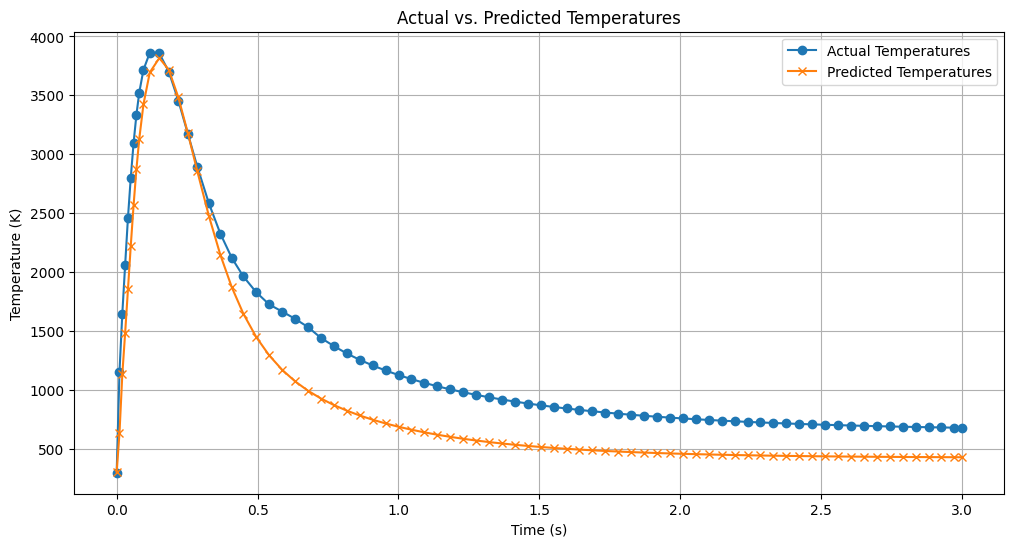

In [29]:
import torch
import matplotlib.pyplot as plt

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.01: 1156.4,
    0.02: 1647.67,
    0.03: 2059,
    0.04: 2460.56,
    0.05: 2802.08,
    0.06: 3095.13,
    0.07: 3333.74,
    0.08: 3522.37,
    0.095: 3716.1,
    0.1175: 3861.45,
    0.15125: 3856.13,
    0.185: 3699.93,
    0.21875: 3455.93,
    0.2525: 3174.75,
    0.28625: 2892.91,
    0.327072: 2584.28,
    0.367894: 2326.57,
    0.408716: 2119.76,
    0.449538: 1963.33,
    0.495412: 1828.76,
    0.541287: 1725.42,
    0.587162: 1665.62,
    0.633037: 1603.89,
    0.678912: 1533.64,
    0.724787: 1441.6,
    0.770662: 1372.63,
    0.816536: 1309.83,
    0.862411: 1256.1,
    0.908286: 1208.19,
    0.954161: 1165.47,
    1.00004: 1127,
    1.04591: 1092.19,
    1.09179: 1060.57,
    1.13766: 1031.72,
    1.18354: 1005.33,
    1.22941: 981.101,
    1.27528: 958.807,
    1.32116: 938.246,
    1.36703: 919.249,
    1.41291: 901.666,
    1.45878: 885.368,
    1.50466: 870.241,
    1.55053: 856.184,
    1.59641: 843.106,
    1.64228: 830.928,
    1.68816: 819.578,
    1.73403: 808.992,
    1.77991: 799.111,
    1.82578: 789.883,
    1.87166: 781.259,
    1.91753: 773.195,
    1.96341: 765.654,
    2.00928: 758.598,
    2.05516: 751.992,
    2.10103: 745.806,
    2.14691: 740.011,
    2.19278: 734.582,
    2.23866: 729.494,
    2.28453: 724.726,
    2.33041: 720.256,
    2.37628: 716.066,
    2.42216: 712.138,
    2.46803: 708.456,
    2.51391: 705.005,
    2.55978: 701.771,
    2.60565: 698.74,
    2.65153: 695.9,
    2.6974: 693.24,
    2.74328: 690.749,
    2.78915: 688.418,
    2.83503: 686.236,
    2.8809: 684.196,
    2.92678: 682.288,
    2.97265: 680.506,
    3.0: 679.487
}

# Ensure all selected times are present in the data_points dictionary
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0]

# Filter selected_time_values to ensure they exist in data_points keys
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[5.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(net(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in selected_time_values]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in selected_time_values]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", selected_time_values)
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.show()


# 6- 5- 6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.50466, 2.00928, 2.55978, 3.0]
Actual Temperatures: [298.15, 1553.75, 2381.08, 2161.91, 978.458, 829.64, 753.299, 721.98]
Predicted Temperatures: [np.float32(299.81567), np.float32(1130.5966), np.float32(2162.7568), np.float32(1866.2338), np.float32(567.25507), np.float32(484.28326), np.float32(451.161), np.float32(440.59827)]


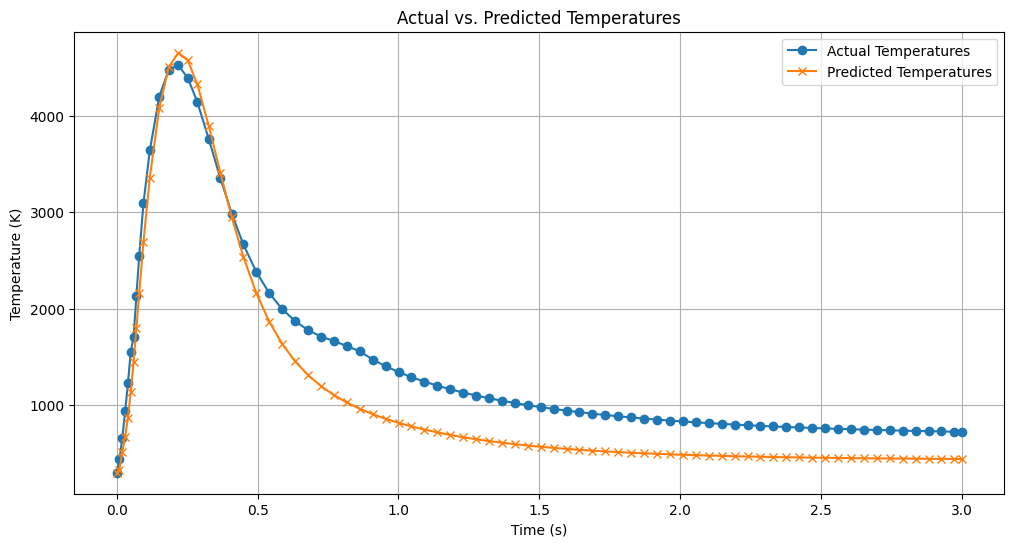

In [33]:
import torch
import matplotlib.pyplot as plt

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.01: 440.328,
    0.02: 658.653,
    0.03: 933.155,
    0.04: 1226.12,
    0.05: 1553.75,
    0.06: 1708.75,
    0.07: 2132.63,
    0.08: 2550.1,
    0.095: 3091.14,
    0.1175: 3640.23,
    0.15125: 4199.93,
    0.185: 4478.9,
    0.21875: 4523.45,
    0.2525: 4391.23,
    0.28625: 4142.29,
    0.327072: 3755.52,
    0.367894: 3353.82,
    0.408716: 2982.9,
    0.449538: 2665.68,
    0.495412: 2381.08,
    0.541287: 2161.91,
    0.587162: 1995.12,
    0.633037: 1871.38,
    0.678912: 1777.16,
    0.724787: 1710.77,
    0.770662: 1664.13,
    0.816536: 1612.6,
    0.862411: 1557.88,
    0.908286: 1472.05,
    0.954161: 1403.31,
    1.00004: 1342.46,
    1.04591: 1289.79,
    1.09179: 1243.23,
    1.13766: 1201.56,
    1.18354: 1164.03,
    1.22941: 1130.01,
    1.27528: 1099.04,
    1.32116: 1070.72,
    1.36703: 1044.75,
    1.41291: 1020.86,
    1.45878: 998.824,
    1.50466: 978.458,
    1.55053: 959.594,
    1.59641: 942.094,
    1.64228: 925.834,
    1.68816: 910.707,
    1.73403: 896.617,
    1.77991: 883.479,
    1.82578: 871.215,
    1.87166: 859.759,
    1.91753: 849.047,
    1.96341: 839.024,
    2.00928: 829.64,
    2.05516: 820.846,
    2.10103: 812.603,
    2.14691: 804.871,
    2.19278: 797.614,
    2.23866: 790.802,
    2.28453: 784.403,
    2.33041: 778.389,
    2.37628: 772.737,
    2.42216: 767.424,
    2.46803: 762.426,
    2.51391: 757.724,
    2.55978: 753.299,
    2.60565: 749.134,
    2.65153: 745.213,
    2.6974: 741.52,
    2.74328: 738.043,
    2.78915: 734.769,
    2.83503: 731.684,
    2.8809: 728.778,
    2.92678: 726.041,
    2.97265: 723.463,
    3.0: 721.98
}

# Selecting specific time values manually based on peaks, middle, and low points
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.0, 1.50466, 2.00928, 2.55978, 3.0]

# Ensure selected_time_values exist in data_points
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[6.0, 5.0, 6.0, t] for t in sorted(data_points.keys()) if t <= 3.0]

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Assuming 'model' is defined and loaded elsewhere in your code
# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(net(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in selected_time_values]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in selected_time_values]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", selected_time_values)
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
filtered_times = [t for t in data_points.keys() if t <= 3.0]
filtered_actual_temps = [data_points[t] for t in filtered_times]
plt.plot(filtered_times, filtered_actual_temps, 'o-', label='Actual Temperatures')
plt.plot(filtered_times, Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.show()


# 8-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]
Actual Temperatures: [298.15, 299.913, 4305.89, 3841.14, 1558.62, 930.434, 806.78, 804.444]
Predicted Temperatures: [np.float32(298.21906), np.float32(308.3661), np.float32(4570.053), np.float32(4014.5537), np.float32(915.0713), np.float32(523.8442), np.float32(465.41364), np.float32(464.51862)]


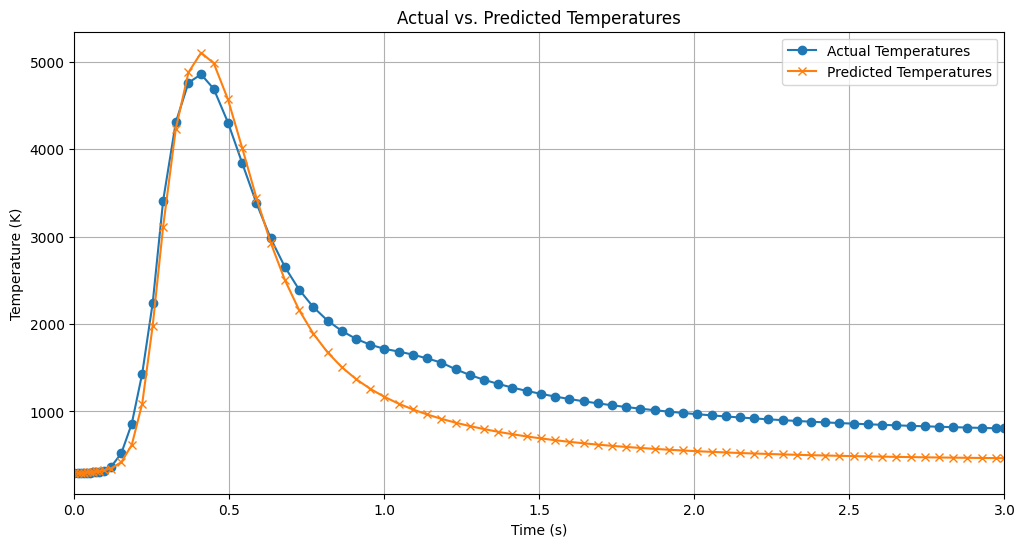

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.01: 298.166,
    0.02: 298.241,
    0.03: 298.459,
    0.04: 298.95,
    0.05: 299.913,
    0.06: 301.616,
    0.07: 304.416,
    0.08: 308.797,
    0.095: 321.196,
    0.1175: 362.263,
    0.15125: 519.519,
    0.185: 858.746,
    0.21875: 1432.81,
    0.2525: 2238.72,
    0.28625: 3411.5,
    0.327072: 4307.99,
    0.367894: 4761.74,
    0.408716: 4857.31,
    0.449538: 4690.82,
    0.495412: 4305.89,
    0.541287: 3841.14,
    0.587162: 3383.43,
    0.633037: 2981.8,
    0.678912: 2653,
    0.724787: 2394.17,
    0.770662: 2193.61,
    0.816536: 2039.44,
    0.862411: 1921.19,
    0.908286: 1830.26,
    0.954161: 1763.24,
    1.00004: 1715.74,
    1.04591: 1684.91,
    1.09179: 1649.71,
    1.13766: 1606.56,
    1.18354: 1558.62,
    1.22941: 1482.62,
    1.27528: 1416.77,
    1.32116: 1361.95,
    1.36703: 1314.45,
    1.41291: 1272.44,
    1.45878: 1234.82,
    1.50466: 1200.86,
    1.55053: 1170,
    1.59641: 1141.82,
    1.64228: 1115.96,
    1.68816: 1092.17,
    1.73403: 1070.2,
    1.77991: 1049.87,
    1.82578: 1031.02,
    1.87166: 1013.5,
    1.91753: 997.185,
    1.96341: 981.977,
    2.00928: 967.777,
    2.05516: 954.501,
    2.10103: 942.075,
    2.14691: 930.434,
    2.19278: 919.518,
    2.23866: 909.272,
    2.28453: 899.648,
    2.33041: 890.601,
    2.37628: 882.091,
    2.42216: 874.08,
    2.46803: 866.533,
    2.51391: 859.421,
    2.55978: 852.713,
    2.60565: 846.384,
    2.65153: 840.408,
    2.6974: 834.764,
    2.74328: 829.43,
    2.78915: 824.387,
    2.83503: 819.616,
    2.8809: 815.102,
    2.92678: 810.828,
    2.97265: 806.78,
    3.0: 804.444
}

# Ensure all selected times are present in the data_points dictionary
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]

# Filter selected_time_values to ensure they exist in data_points keys
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[8.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Assuming 'net' is defined and loaded elsewhere in your code

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(net(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in selected_time_values]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in selected_time_values]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", selected_time_values)
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.xlim(0, 3)
plt.show()


# 10-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]
Actual Temperatures: [298.15, 298.151, 3746.6, 4589.99, 1760.86, 1045.72, 879.467, 876.37]
Predicted Temperatures: [np.float32(298.16125), np.float32(298.29037), np.float32(3470.0522), np.float32(4590.7935), np.float32(1258.1864), np.float32(583.6439), np.float32(491.92758), np.float32(490.47418)]


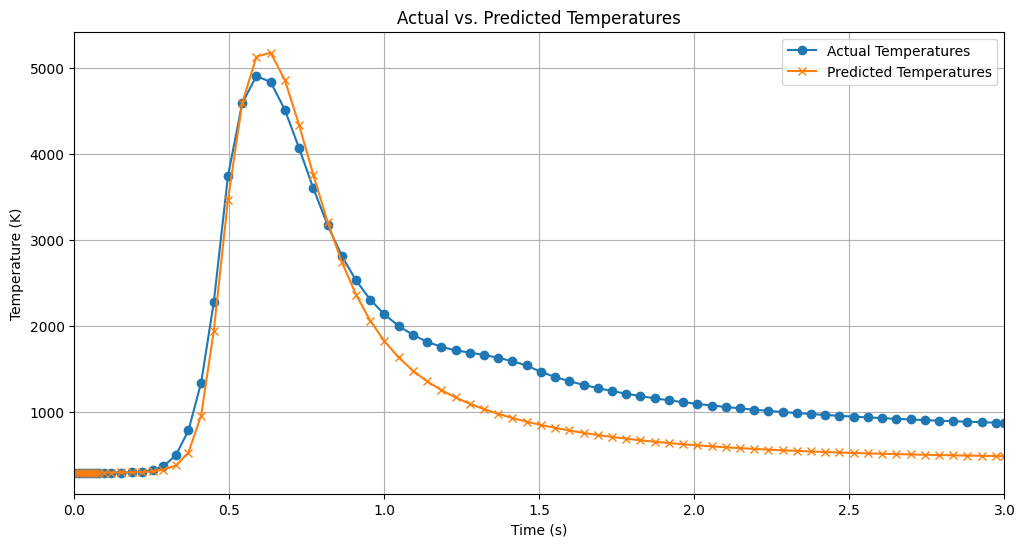

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.01: 298.15,
    0.02: 298.15,
    0.03: 298.15,
    0.04: 298.15,
    0.05: 298.151,
    0.06: 298.152,
    0.07: 298.156,
    0.08: 298.162,
    0.095: 298.186,
    0.1175: 298.323,
    0.15125: 299.354,
    0.185: 302.556,
    0.21875: 310.765,
    0.2525: 329.69,
    0.28625: 371.464,
    0.327072: 499.812,
    0.367894: 789.637,
    0.408716: 1342.4,
    0.449538: 2275.93,
    0.495412: 3746.6,
    0.541287: 4589.99,
    0.587162: 4907.17,
    0.633037: 4836.1,
    0.678912: 4514.17,
    0.724787: 4069.3,
    0.770662: 3602.17,
    0.816536: 3176.06,
    0.862411: 2818.71,
    0.908286: 2533.2,
    0.954161: 2310.16,
    1.00004: 2137.2,
    1.04591: 2003.23,
    1.09179: 1899.53,
    1.13766: 1819.67,
    1.18354: 1760.86,
    1.22941: 1719.11,
    1.27528: 1694.51,
    1.32116: 1665.97,
    1.36703: 1633.36,
    1.41291: 1593.42,
    1.45878: 1544.44,
    1.50466: 1469.79,
    1.55053: 1410.74,
    1.59641: 1361.5,
    1.64228: 1318.78,
    1.68816: 1280.95,
    1.73403: 1247.03,
    1.77991: 1216.34,
    1.82578: 1188.4,
    1.87166: 1162.83,
    1.91753: 1139.33,
    1.96341: 1117.67,
    2.00928: 1097.63,
    2.05516: 1079.05,
    2.10103: 1061.79,
    2.14691: 1045.72,
    2.19278: 1030.74,
    2.23866: 1016.75,
    2.28453: 1003.66,
    2.33041: 991.411,
    2.37628: 979.923,
    2.42216: 969.141,
    2.46803: 959.01,
    2.51391: 949.484,
    2.55978: 940.517,
    2.60565: 932.072,
    2.65153: 924.111,
    2.6974: 916.601,
    2.74328: 909.512,
    2.78915: 902.816,
    2.83503: 896.486,
    2.8809: 890.499,
    2.92678: 884.833,
    2.97265: 879.467,
    3.0: 876.37
}

# Ensure all selected times are present in the data_points dictionary
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]

# Filter selected_time_values to ensure they exist in data_points keys
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[10.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Assuming 'net' is defined and loaded elsewhere in your code

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(net(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in selected_time_values]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in selected_time_values]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", selected_time_values)
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.xlim(0, 3)
plt.show()


# 15-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]
Actual Temperatures: [298.15, 298.15, 298.421, 298.899, 4499.49, 1373.61, 1017.66, 1012.14]
Predicted Temperatures: [np.float32(298.15704), np.float32(298.15817), np.float32(299.3084), np.float32(299.72223), np.float32(4932.587), np.float32(803.1627), np.float32(567.0383), np.float32(563.6795)]


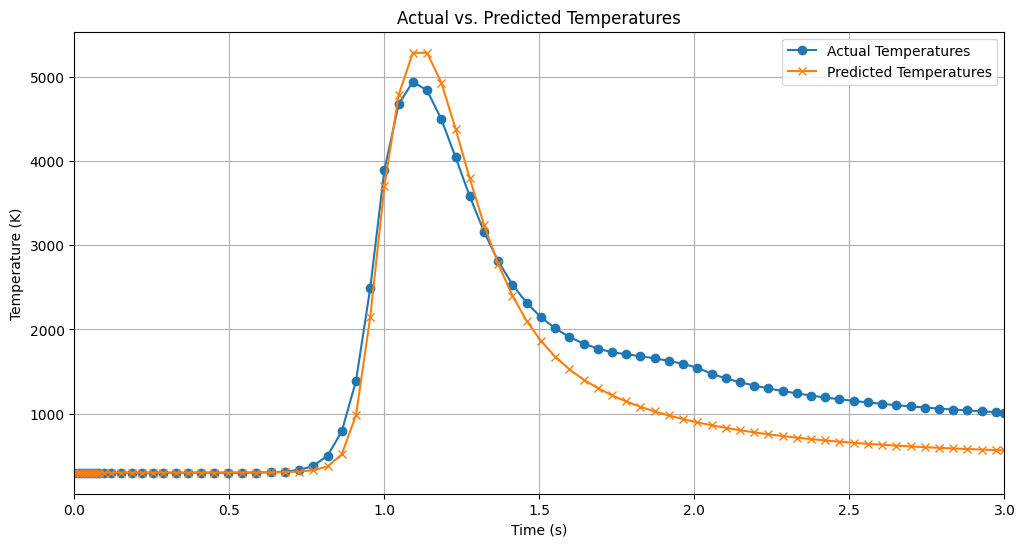

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.01: 298.15,
    0.02: 298.15,
    0.03: 298.15,
    0.04: 298.15,
    0.05: 298.15,
    0.06: 298.15,
    0.07: 298.15,
    0.08: 298.15,
    0.095: 298.15,
    0.1175: 298.15,
    0.15125: 298.15,
    0.185: 298.15,
    0.21875: 298.15,
    0.2525: 298.15,
    0.28625: 298.151,
    0.327072: 298.154,
    0.367894: 298.162,
    0.408716: 298.184,
    0.449538: 298.241,
    0.495412: 298.421,
    0.541287: 298.899,
    0.587162: 300.119,
    0.633037: 303.182,
    0.678912: 310.867,
    0.724787: 330.194,
    0.770662: 378.919,
    0.816536: 500.53,
    0.862411: 788.315,
    0.908286: 1387.56,
    0.954161: 2488.12,
    1.00004: 3895.71,
    1.04591: 4674.61,
    1.09179: 4943.83,
    1.13766: 4839.87,
    1.18354: 4499.49,
    1.22941: 4048.24,
    1.27528: 3583.06,
    1.32116: 3163.17,
    1.36703: 2813.13,
    1.41291: 2534.1,
    1.45878: 2316.08,
    1.50466: 2146.51,
    1.55053: 2014.4,
    1.59641: 1911.59,
    1.64228: 1832.33,
    1.68816: 1772.99,
    1.73403: 1730.04,
    1.77991: 1705.71,
    1.82578: 1682.79,
    1.87166: 1656.71,
    1.91753: 1627.23,
    1.96341: 1591.23,
    2.00928: 1546,
    2.05516: 1474.31,
    2.10103: 1419.19,
    2.14691: 1373.61,
    2.19278: 1334.31,
    2.23866: 1299.67,
    2.28453: 1268.7,
    2.33041: 1240.74,
    2.37628: 1215.33,
    2.42216: 1192.11,
    2.46803: 1170.8,
    2.51391: 1151.18,
    2.55978: 1133.06,
    2.60565: 1116.29,
    2.65153: 1100.72,
    2.6974: 1086.26,
    2.74328: 1072.79,
    2.78915: 1060.23,
    2.83503: 1048.5,
    2.8809: 1037.54,
    2.92678: 1027.27,
    2.97265: 1017.66,
    3.0: 1012.14
}

# Ensure all selected times are present in the data_points dictionary
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]

# Filter selected_time_values to ensure they exist in data_points keys
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[15.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Assuming 'net' is defined and loaded elsewhere in your code

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(net(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in selected_time_values]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in selected_time_values]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", selected_time_values)
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.xlim(0, 3)
plt.show()


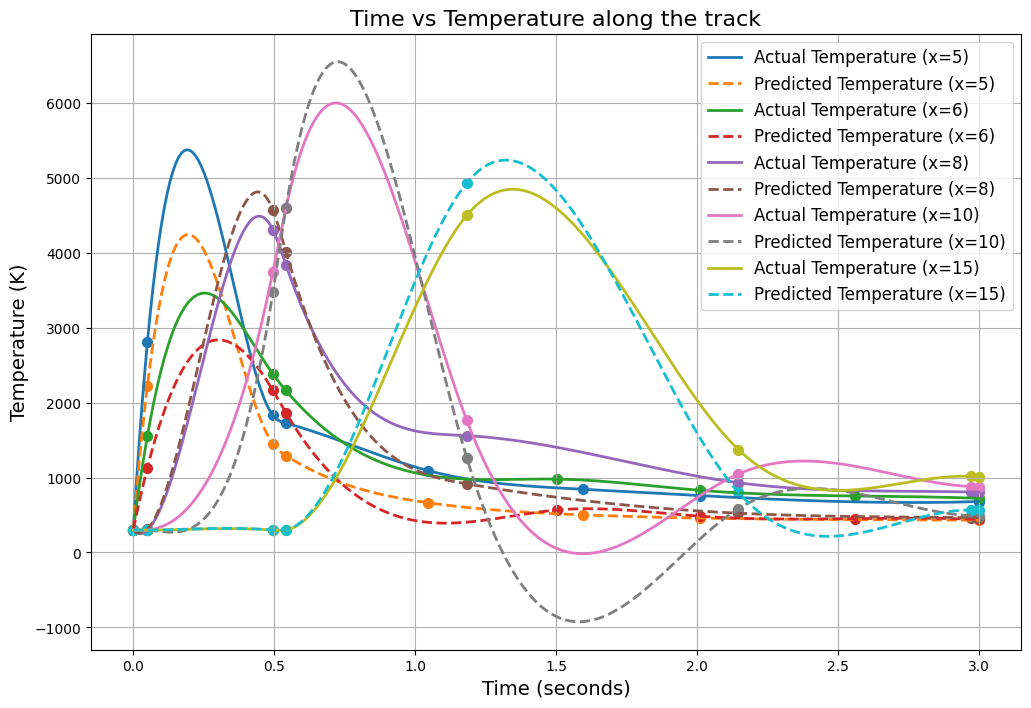

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Define dictionaries for actual and predicted temperatures
actual_data = {
    5: {
        'time':[0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0],
        'temperature': [298.15, 2802.08, 1828.76, 1725.42, 1092.19, 843.106, 758.598, 679.487]
    },

    6: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.50466, 2.00928, 2.55978, 3.0],
        'temperature': [298.15, 1553.75, 2381.08, 2161.91, 978.458, 829.64, 753.299, 721.98]
    },
    8: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [298.15, 299.913, 4305.89, 3841.14, 1558.62, 930.434, 806.78, 804.444]
    },
        10: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature':  [298.15, 298.151, 3746.6, 4589.99, 1760.86, 1045.72, 879.467, 876.37]
    },
    15: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature':  [298.15, 298.15, 298.421, 298.899, 4499.49, 1373.61, 1017.66, 1012.14]
    },
}

predicted_data = {
        5: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0],
        'temperature': [np.float32(305.1553), np.float32(2223.4072), np.float32(1448.2865), np.float32(1293.3102), np.float32(663.1323), np.float32(501.0749), np.float32(458.55316), np.float32(429.5833)]
    },
    6: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.50466, 2.00928, 2.55978, 3.0],
        'temperature': [np.float32(299.81567), np.float32(1130.5966), np.float32(2162.7568), np.float32(1866.2338), np.float32(567.25507), np.float32(484.28326), np.float32(451.161), np.float32(440.59827)]
    },
    8: {
        'time':  [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [np.float32(298.21906), np.float32(308.3661), np.float32(4570.053), np.float32(4014.5537), np.float32(915.0713), np.float32(523.8442), np.float32(465.41364), np.float32(464.51862)]
    },

    10: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [np.float32(298.16125), np.float32(298.29037), np.float32(3470.0522), np.float32(4590.7935), np.float32(1258.1864), np.float32(583.6439), np.float32(491.92758), np.float32(490.47418)]
    },
    15: {
        'time':  [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [np.float32(298.15704), np.float32(298.15817), np.float32(299.3084), np.float32(299.72223), np.float32(4932.587), np.float32(803.1627), np.float32(567.0383), np.float32(563.6795)]
    },

}

# Plotting the provided data points and predictions
plt.figure(figsize=(12, 8))

# Loop through each x value in actual_data
for x in actual_data.keys():
    actual_times = actual_data[x]['time']
    actual_temps = actual_data[x]['temperature']
    predicted_temps = predicted_data[x]['temperature']
    
    # Generate smooth data points using interpolation
    time_smooth = np.linspace(min(actual_times), max(actual_times), 300)
    
    actual_spline = make_interp_spline(actual_times, actual_temps, k=3)
    predicted_spline = make_interp_spline(actual_times, predicted_temps, k=3)
    
    actual_temperatures_smooth = actual_spline(time_smooth)
    predicted_temperatures_smooth = predicted_spline(time_smooth)
    
    # Plot actual and predicted data with smoothing
    plt.plot(time_smooth, actual_temperatures_smooth, '-', label=f'Actual Temperature (x={x})', linewidth=2)
    plt.plot(time_smooth, predicted_temperatures_smooth, '--', label=f'Predicted Temperature (x={x})', linewidth=2)
    plt.scatter(actual_times, actual_temps, s=50)  # original points for actual temperature
    plt.scatter(actual_times, predicted_temps, s=50)  # original points for predicted temperature

plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Temperature (K)', fontsize=14)
plt.title('Time vs Temperature along the track', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


# predictions and actuals lists for reference

In [ ]:
# 5-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0]
Actual Temperatures: [298.15, 2802.08, 1828.76, 1725.42, 1092.19, 843.106, 758.598, 679.487]
Predicted Temperatures: [np.float32(305.1553), np.float32(2223.4072), np.float32(1448.2865), np.float32(1293.3102), np.float32(663.1323), np.float32(501.0749), np.float32(458.55316), np.float32(429.5833)]



# 6-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.50466, 2.00928, 2.55978, 3.0]
Actual Temperatures: [298.15, 1553.75, 2381.08, 2161.91, 978.458, 829.64, 753.299, 721.98]
Predicted Temperatures: [np.float32(299.81567), np.float32(1130.5966), np.float32(2162.7568), np.float32(1866.2338), np.float32(567.25507), np.float32(484.28326), np.float32(451.161), np.float32(440.59827)]



#8-5-6

Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]
Actual Temperatures: [298.15, 299.913, 4305.89, 3841.14, 1558.62, 930.434, 806.78, 804.444]
Predicted Temperatures: [np.float32(298.21906), np.float32(308.3661), np.float32(4570.053), np.float32(4014.5537), np.float32(915.0713), np.float32(523.8442), np.float32(465.41364), np.float32(464.51862)]



# 10-5-6
Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]
Actual Temperatures: [298.15, 298.151, 3746.6, 4589.99, 1760.86, 1045.72, 879.467, 876.37]
Predicted Temperatures: [np.float32(298.16125), np.float32(298.29037), np.float32(3470.0522), np.float32(4590.7935), np.float32(1258.1864), np.float32(583.6439), np.float32(491.92758), np.float32(490.47418)]



# 15-5-6


Selected Times: [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]
Actual Temperatures: [298.15, 298.15, 298.421, 298.899, 4499.49, 1373.61, 1017.66, 1012.14]
Predicted Temperatures: [np.float32(298.15704), np.float32(298.15817), np.float32(299.3084), np.float32(299.72223), np.float32(4932.587), np.float32(803.1627), np.float32(567.0383), np.float32(563.6795)]



# Error analysis

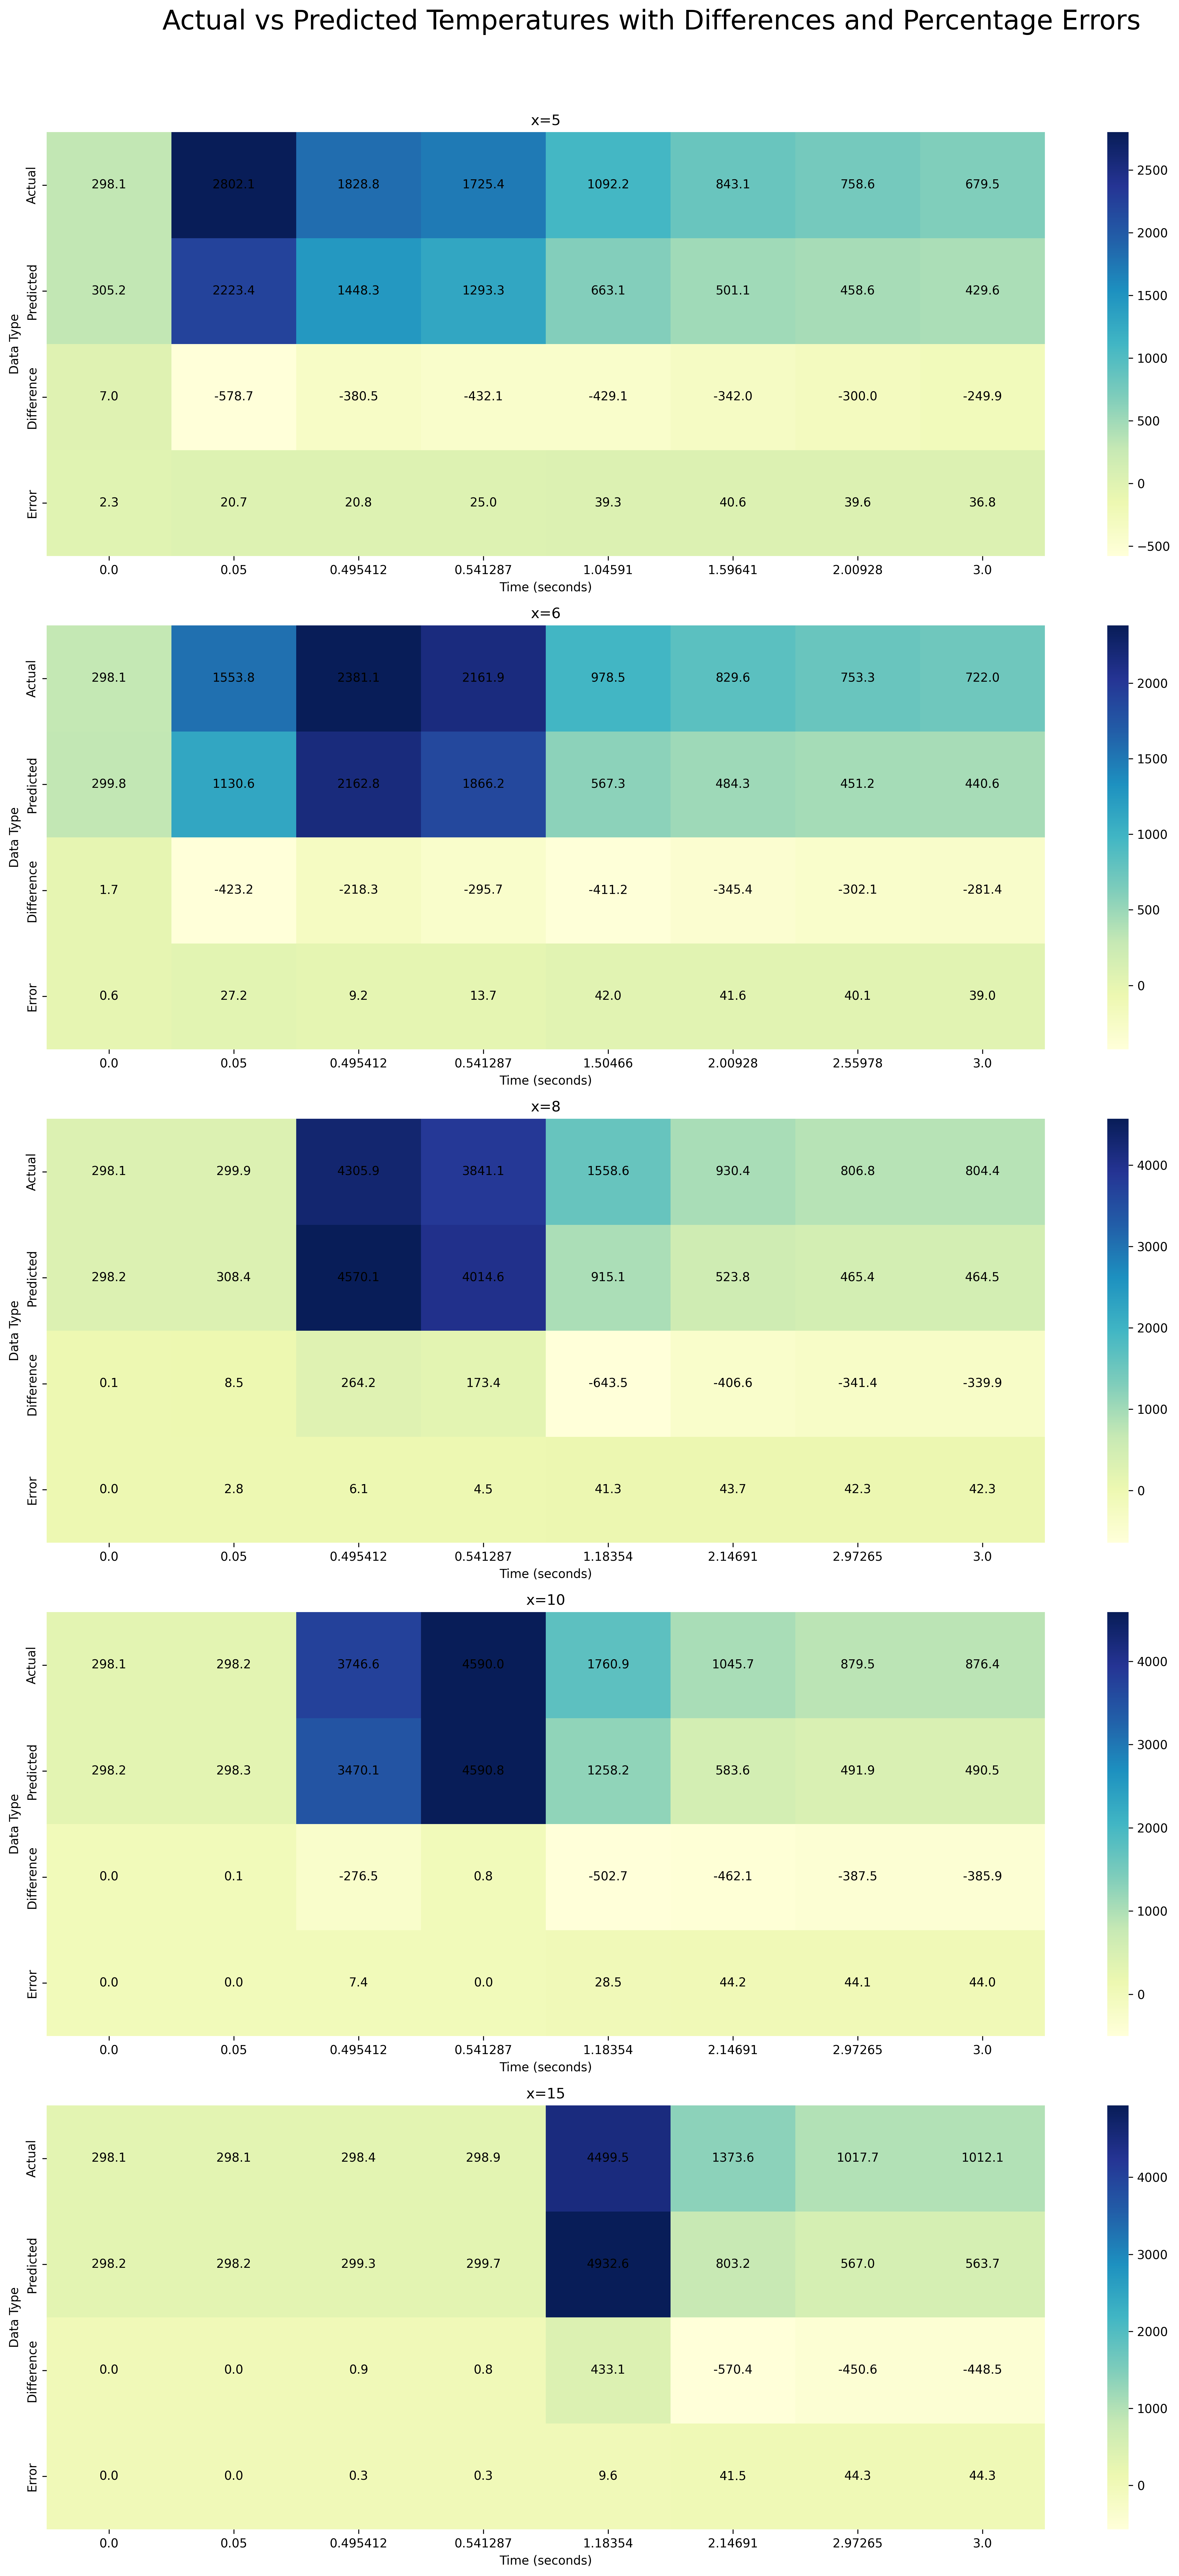

Average Percentage Error: 23.25%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define dictionaries for actual and predicted temperatures
actual_data = {
    5: {
        'time':[0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0],
        'temperature': [298.15, 2802.08, 1828.76, 1725.42, 1092.19, 843.106, 758.598, 679.487]
    },

    6: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.50466, 2.00928, 2.55978, 3.0],
        'temperature': [298.15, 1553.75, 2381.08, 2161.91, 978.458, 829.64, 753.299, 721.98]
    },
    8: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [298.15, 299.913, 4305.89, 3841.14, 1558.62, 930.434, 806.78, 804.444]
    },
        10: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature':  [298.15, 298.151, 3746.6, 4589.99, 1760.86, 1045.72, 879.467, 876.37]
    },
    15: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature':  [298.15, 298.15, 298.421, 298.899, 4499.49, 1373.61, 1017.66, 1012.14]
    },
}

predicted_data = {
        5: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.04591, 1.59641, 2.00928, 3.0],
        'temperature': [np.float32(305.1553), np.float32(2223.4072), np.float32(1448.2865), np.float32(1293.3102), np.float32(663.1323), np.float32(501.0749), np.float32(458.55316), np.float32(429.5833)]
    },
    6: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.50466, 2.00928, 2.55978, 3.0],
        'temperature': [np.float32(299.81567), np.float32(1130.5966), np.float32(2162.7568), np.float32(1866.2338), np.float32(567.25507), np.float32(484.28326), np.float32(451.161), np.float32(440.59827)]
    },
    8: {
        'time':  [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [np.float32(298.21906), np.float32(308.3661), np.float32(4570.053), np.float32(4014.5537), np.float32(915.0713), np.float32(523.8442), np.float32(465.41364), np.float32(464.51862)]
    },

    10: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [np.float32(298.16125), np.float32(298.29037), np.float32(3470.0522), np.float32(4590.7935), np.float32(1258.1864), np.float32(583.6439), np.float32(491.92758), np.float32(490.47418)]
    },
    15: {
        'time':  [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature': [np.float32(298.15704), np.float32(298.15817), np.float32(299.3084), np.float32(299.72223), np.float32(4932.587), np.float32(803.1627), np.float32(567.0383), np.float32(563.6795)]
    },

}
# Calculate differences and percentage errors
differences = {}
percentage_errors = {}

for x in actual_data.keys():
    actual_temps = np.array(actual_data[x]['temperature'])
    predicted_temps = np.array(predicted_data[x]['temperature'])
    differences[x] = predicted_temps - actual_temps
    percentage_errors[x] = np.abs((actual_temps - predicted_temps) / actual_temps) * 100

# Function to plot heatmaps
def plot_heatmaps(ax, actual, predicted, difference, error, x):
    data_matrix = np.vstack((actual, predicted, difference, error))
    labels = ['Actual', 'Predicted', 'Difference', 'Error']
    
    sns.heatmap(data_matrix, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=actual_data[x]['time'], yticklabels=labels, cbar=True, ax=ax, annot_kws={"color": "black"})
    ax.set_title(f"x={x}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Data Type")

# Create subplots
fig, axs = plt.subplots(len(actual_data), 1, figsize=(15, 6 * len(actual_data)), dpi=300)

# Plot heatmaps for each x value
for i, x in enumerate(actual_data.keys()):
    plot_heatmaps(axs[i], actual_data[x]['temperature'], predicted_data[x]['temperature'], differences[x], percentage_errors[x], x)

fig.suptitle('Actual vs Predicted Temperatures with Differences and Percentage Errors', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculate the average percentage error
all_percentage_errors = np.concatenate([percentage_errors[x] for x in percentage_errors.keys()])
average_percentage_error = np.mean(all_percentage_errors)
print(f'Average Percentage Error: {average_percentage_error:.2f}%')
